1.(Feature Extraction)
• Resize each cropped image to a 224 × 224 pixel image. (Similar to Assignment 1 Question
2(a))

• Normalize the resized image dataset.
• Extract features for each image from the last convolution layer of “ResNet18” (You can follow
https://kozodoi.me/blog/20210527/extracting-features. But you must reference
this website in your solution) (2.5 points)

In [6]:
import os
import shutil
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix

import warnings

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

base_path = "/content/drive/My Drive/DogClassifier4"
image_path = os.path.join(base_path, "Images")
annotations_path = os.path.join(base_path, "Annotations")

repo_path = "/content/dataset"


def is_dir_empty(path):
    return not os.listdir(path)


def copy_data(src, dest):
    try:
        shutil.copytree(src, dest)
        print(f"Data copied successfully from {src} to {dest}.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


if not os.path.exists(image_path) or not os.path.exists(annotations_path) or is_dir_empty(image_path) or is_dir_empty(
        annotations_path):
    if os.path.exists(image_path):
        shutil.rmtree(image_path)
    if os.path.exists(annotations_path):
        shutil.rmtree(annotations_path)

    if not os.path.exists(repo_path):
        os.system(f"git clone https://github.com/Sairam-KSR/Data_Mining {repo_path}")
        print("Repository cloned successfully.")
    else:
        print("Repository already exists. Skipping cloning.")

    copy_data(os.path.join(repo_path, 'Images'), image_path)
    copy_data(os.path.join(repo_path, 'Annotations'), annotations_path)
else:
    print("The required folders already exist in Google Drive and are not empty. Skipping cloning and copying.")


dir_annotations = os.path.join(repo_path, "Annotations")
dir_image = os.path.join(repo_path, "Images")
dir_crop = os.path.join(repo_path, 'Cropped')
dir_feature = os.path.join(repo_path, 'Features')

Mounted at /content/drive
The required folders already exist in Google Drive and are not empty. Skipping cloning and copying.


In [7]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image
import torch
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Normalize

def create_and_list_directories(base_path):
    Path(base_path).mkdir(parents=True, exist_ok=True)
    return [directory for directory in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, directory))]

def process_images_and_annotations(annotations_path, images_path, cropped_path, output_directory, model):
    Path(cropped_path).mkdir(parents=True, exist_ok=True)
    Path(output_directory).mkdir(parents=True, exist_ok=True)
    preprocess_transform = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    hook = torch.nn.Sequential(*(list(model.children())[:-1]))

    for breed in create_and_list_directories(annotations_path):
        breed_annotations_path = os.path.join(annotations_path, breed)
        for file in os.listdir(breed_annotations_path):
            annotation_path = os.path.join(breed_annotations_path, file)
            xml_tree = ET.parse(annotation_path)
            root_element = xml_tree.getroot()
            bounding_boxes = []

            for obj in root_element.findall('object'):
                bbox_xml = obj.find('bndbox')
                bbox = (int(bbox_xml.find("xmin").text), int(bbox_xml.find("ymin").text),
                        int(bbox_xml.find("xmax").text), int(bbox_xml.find("ymax").text))
                bounding_boxes.append(bbox)

            file_name_without_extension = os.path.splitext(file)[0]
            image_file_name = file_name_without_extension + '.jpg'
            original_image_path = os.path.join(images_path, breed, image_file_name)
            output_path = os.path.join(cropped_path, breed, file_name_without_extension + '.jpg')
            create_and_list_directories(os.path.dirname(output_path))

            with Image.open(original_image_path) as image:
                if image.mode == 'RGBA':
                    image = image.convert('RGB')

                for bbox in bounding_boxes:
                    cropped_image = image.crop(bbox)
                    resized_image = cropped_image.resize((224, 224), Image.LANCZOS)
                    resized_image.save(output_path)

            image = read_image(output_path).float() / 255.0
            normalized_image = preprocess_transform(image).unsqueeze(0)
            with torch.no_grad():
                features = hook(normalized_image).squeeze(0).squeeze(-1).squeeze(-1)

            breed_features_directory = Path(os.path.join(output_directory, breed))
            Path(breed_features_directory).mkdir(parents=True, exist_ok=True)
            feature_vector_path = breed_features_directory / (file_name_without_extension + '.pt')
            torch.save(features.cpu(), feature_vector_path)

resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.eval()

process_images_and_annotations(dir_annotations, dir_image, dir_crop, dir_feature, resnet)

print("Feature extraction completed.")

Feature extraction completed.


2.(Dimension Reduction) Perform dimension reduction on your new dog image representation dataset
to reduce the dimension to 2 (similar to Assignment 1 Question 2(f)). (0.5 points)

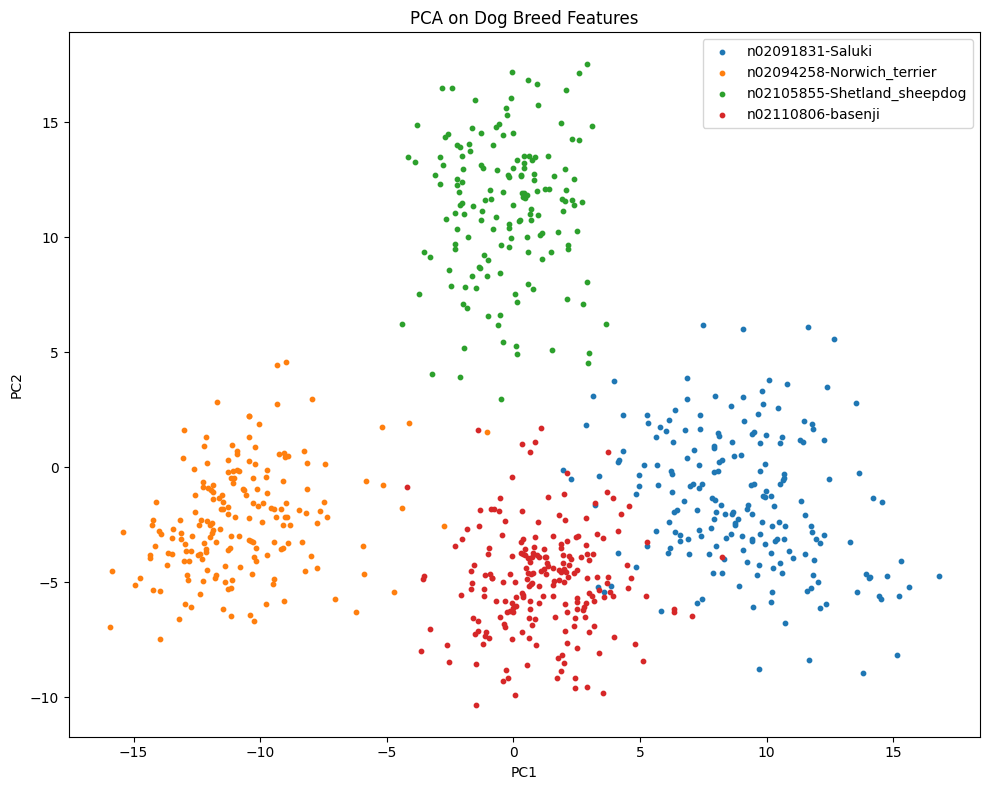

In [8]:
import os
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_and_process_features(features_dir, num_components=2):
    feature_vectors, labels, breed_names = [], [], []
    for breed_index, breed in enumerate(sorted(os.listdir(features_dir))):
        breed_features_dir = os.path.join(features_dir, breed)
        for feature_filename in os.listdir(breed_features_dir):
            feature_vector = torch.load(os.path.join(breed_features_dir, feature_filename))
            feature_vectors.append(feature_vector.numpy())
            labels.append(breed_index)
        breed_names.append(breed)

    scaler = StandardScaler()
    pca = PCA(n_components=num_components)
    features_scaled = scaler.fit_transform(feature_vectors)
    pca_result = pca.fit_transform(features_scaled)
    return pca_result, labels, breed_names

def plot_pca(pca_result, labels, breed_names):
    plt.figure(figsize=(10, 8))
    for breed_index in set(labels):
        idx = [i for i, label in enumerate(labels) if label == breed_index]
        plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=breed_names[breed_index], s=10)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA on Dog Breed Features')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

pca_features, labels, breeds = load_and_process_features(dir_feature, num_components=2)
plot_pca(pca_features, labels, breeds)


3.(Clustering Algorithm) Perform clustering using the following approaches on the 2D dataset you
preprocessed in Item 2:

• K-mean clustering and its variants for 𝐾 = 4:
(a) K-means clustering: (Use KMeans with init = ‘Random’) (0.5 point)

(b) KMeans with init=‘k-means++’ (0.5 point)
1

(c) Bisecting K-means (sklearn.cluster.BisectingKMeans with init = ‘Random’) (0.5 point)

(d) spectral clustering (sklearn.cluster.SpectralClustering with default parameters) (0.5 point)

• DBSCAN (0.5 point)
– What are the eps and min samples parameter values you used to get 4 clusters? (0.5
point)

• Agglomerative clustering (i.e., hierarchical clustering) - use sklearn.cluster.AgglomerativeClustering
with number of clusters set to 4

(a) Single link (MIN), (0.5 point)

(b) Complete link (MAX), (0.5 point)

(c) Group Average, and (0.5 point)

(d) Ward’s method (0.5 point)

Use the four linkage values ‘ward’, ‘complete’, ‘average’, ‘single’ for sklearn.cluster.
AgglomerativeClustering

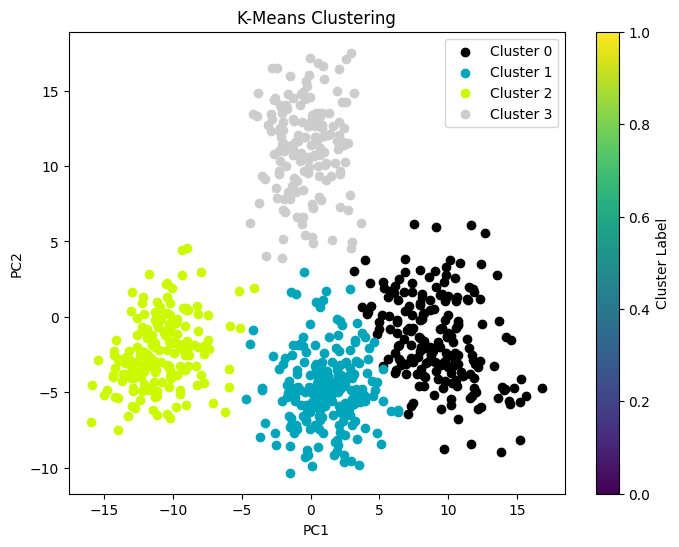

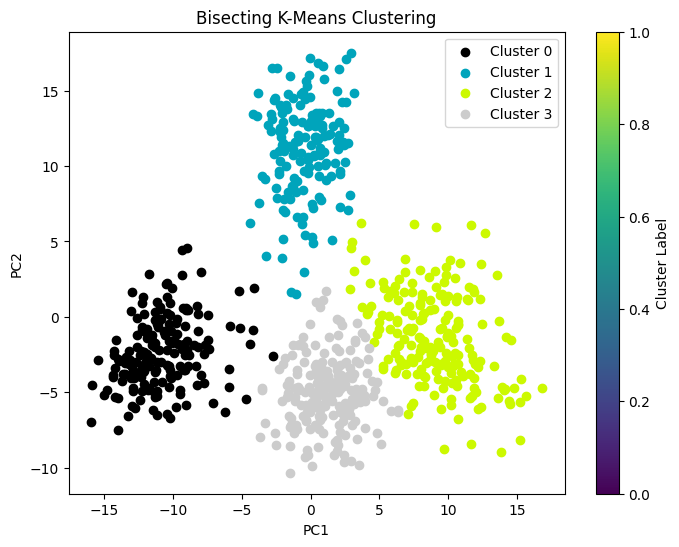

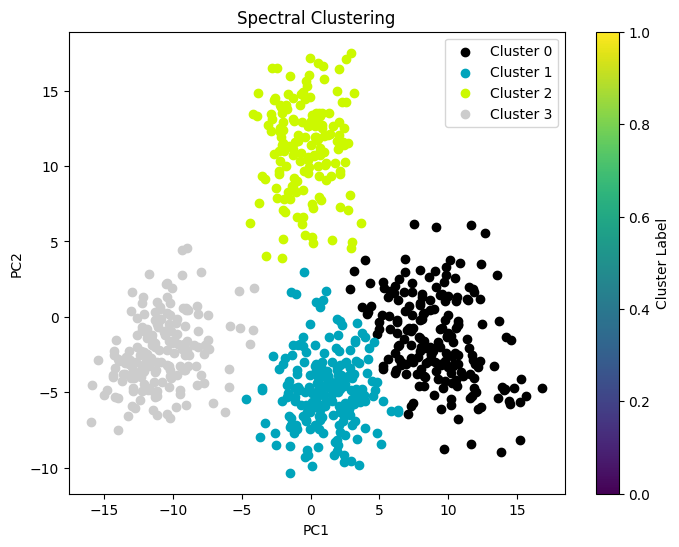

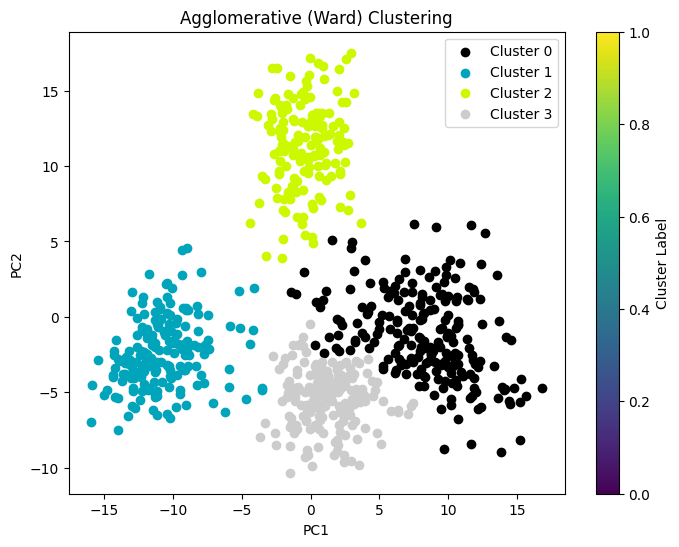

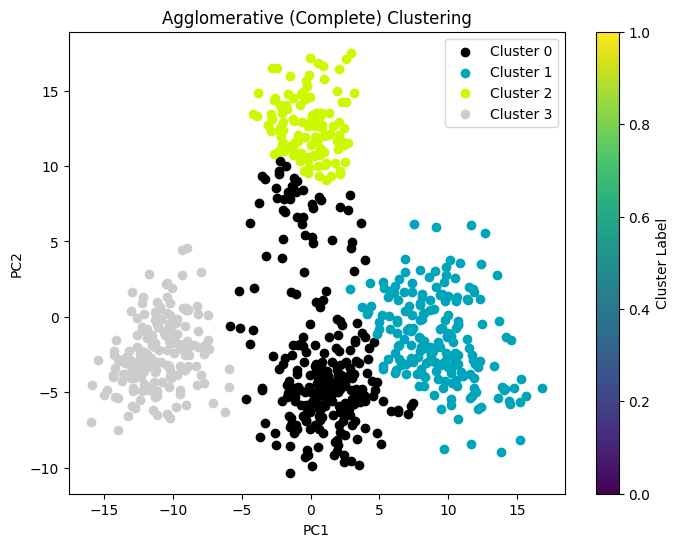

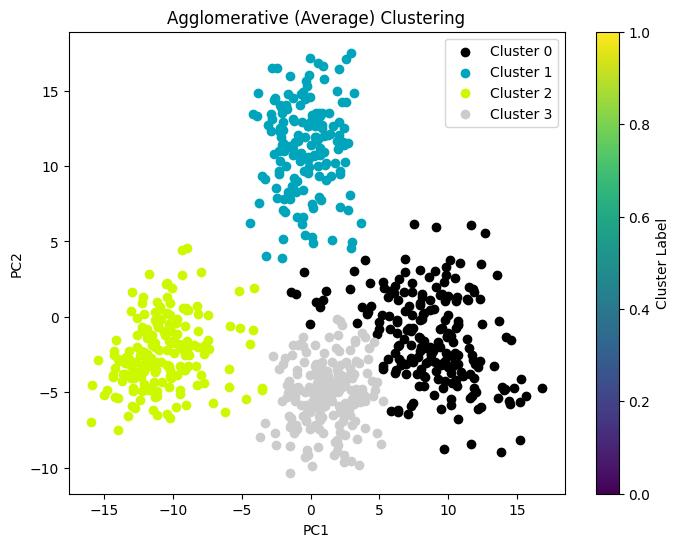

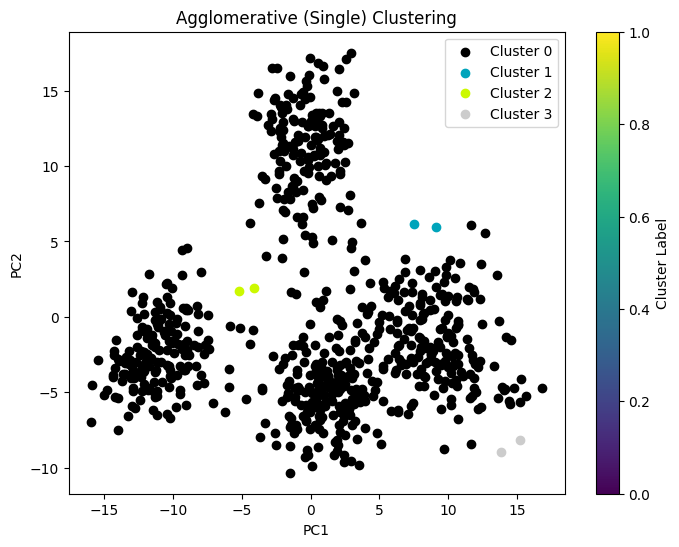

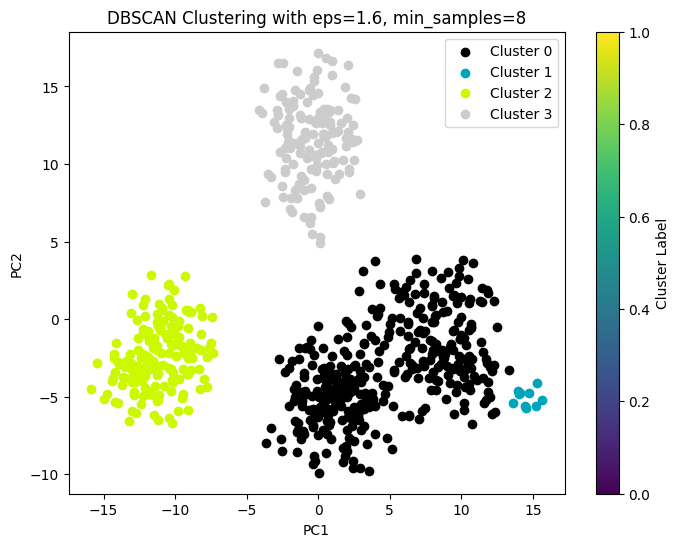




DBSCAN clustering with eps=1.6, min_samples=8 resulted in 4 clusters.


In [9]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, BisectingKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

def load_features_and_preprocess(features_dir, num_components=2):
    feature_vectors, labels, breed_names = [], [], []
    for breed_index, breed in enumerate(sorted(os.listdir(features_dir))):
        breed_features_dir = os.path.join(features_dir, breed)
        for feature_filename in os.listdir(breed_features_dir):
            feature_vector = torch.load(os.path.join(breed_features_dir, feature_filename))
            feature_vectors.append(feature_vector.numpy())
            labels.append(breed_index)
        breed_names.append(breed)

    scaler = StandardScaler()
    pca = PCA(n_components=num_components)
    features_scaled = scaler.fit_transform(feature_vectors)
    pca_result = pca.fit_transform(features_scaled)
    return pca_result, labels, breed_names

def plot_clusters(data, labels, title='Cluster Plot'):
    plt.figure(figsize=(8, 6))
    core_samples_mask = labels != -1
    unique_labels = set(labels) - {-1}
    for label in unique_labels:
        label_mask = labels == label
        plt.scatter(data[core_samples_mask & label_mask, 0], data[core_samples_mask & label_mask, 1],
                    c=[plt.cm.nipy_spectral(float(label) / max(labels))], marker='o', label=f'Cluster {label}')
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.colorbar(label='Cluster Label')
    plt.show()

pca_features, _, _ = load_features_and_preprocess(dir_feature)

clusterer_constructors = {
    'K-Means': KMeans(n_clusters=4, n_init=10, random_state=42),
    'Bisecting K-Means': BisectingKMeans(n_clusters=4),
    'Spectral': SpectralClustering(n_clusters=4, random_state=42),
    'Agglomerative (Ward)': AgglomerativeClustering(n_clusters=4),
    'Agglomerative (Complete)': AgglomerativeClustering(n_clusters=4, linkage='complete'),
    'Agglomerative (Average)': AgglomerativeClustering(n_clusters=4, linkage='average'),
    'Agglomerative (Single)': AgglomerativeClustering(n_clusters=4, linkage='single')
}

clustering_labels = {}
for name, clusterer in clusterer_constructors.items():
    labels_pred = clusterer.fit_predict(pca_features)
    clustering_labels[name] = labels_pred
    plot_clusters(pca_features, labels_pred, title=f'{name} Clustering')

best_eps = 1.6
best_min_samples = 8
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_dbscan_labels = dbscan.fit_predict(pca_features)
num_clusters = len(set(best_dbscan_labels)) - (1 if -1 in best_dbscan_labels else 0)

if num_clusters == 4:
    plot_clusters(pca_features, best_dbscan_labels, title=f'DBSCAN Clustering with eps={best_eps}, min_samples={best_min_samples}')
    print(f'\n\n\nDBSCAN clustering with eps={best_eps}, min_samples={best_min_samples} resulted in {num_clusters} clusters.')
else:
    print(f'DBSCAN clustering with eps={best_eps}, min_samples={best_min_samples} did not result in the desired number of clusters.')


4.(Clustering Evaluations) For all the methods in Item 3:

(a) Perform clustering performance evaluation using Fowlkes-Mallows index (sklearn.metrics.fowlkes
mallows score). Compute the Fowlkes-Mallows index for each method on the 2D dataset. (0.5
point)

(b) Perform clustering performance evaluation using Silhouette Coefficient (sklearn.metrics.silhouette score).
Compute the Silhouette Coefficient for each method. (0.5 point)

(c) Rank the methods from the best to the worst for our dataset based on Fowlkes-Mallows index.
(0.5 point)

(d) Rank the methods from the best to the worst for our dataset based on Silhouette Coefficient.
(0.5 point)



In [10]:
from sklearn.metrics import fowlkes_mallows_score, silhouette_score

print("\nEvaluation Results:")
print("Method\t\t\tFowlkes-Mallows Score\tSilhouette Coefficient")

results = []
for method_name, labels_pred in clustering_labels.items():
    fm_score = fowlkes_mallows_score(labels, labels_pred)
    si_score = silhouette_score(pca_features, labels_pred) if len(set(labels_pred)) > 1 else -1
    results.append((method_name, fm_score, si_score))
    print(f"{method_name}\t\t{fm_score:.4f}\t\t\t{si_score:.4f}")

# Print rankings
fm_ranking = sorted(results, key=lambda item: item[1], reverse=True)
si_ranking = sorted(results, key=lambda item: item[2], reverse=True)

print("\nRanking based on Fowlkes-Mallows Index")
for rank, (method, fm_score, _) in enumerate(fm_ranking, 1):
    print(f"{rank}. {method}: {fm_score:.4f}")

print("\nRanking based on Silhouette Coefficient")
for rank, (method, _, si_score) in enumerate(si_ranking, 1):
    print(f"{rank}. {method}: {si_score:.4f}")



Evaluation Results:
Method			Fowlkes-Mallows Score	Silhouette Coefficient
K-Means		0.9419			0.5919
Bisecting K-Means		0.9435			0.5856
Spectral		0.9474			0.5914
Agglomerative (Ward)		0.8991			0.5633
Agglomerative (Complete)		0.8357			0.5070
Agglomerative (Average)		0.9293			0.5780
Agglomerative (Single)		0.4976			-0.3207

Ranking based on Fowlkes-Mallows Index
1. Spectral: 0.9474
2. Bisecting K-Means: 0.9435
3. K-Means: 0.9419
4. Agglomerative (Average): 0.9293
5. Agglomerative (Ward): 0.8991
6. Agglomerative (Complete): 0.8357
7. Agglomerative (Single): 0.4976

Ranking based on Silhouette Coefficient
1. K-Means: 0.5919
2. Spectral: 0.5914
3. Bisecting K-Means: 0.5856
4. Agglomerative (Average): 0.5780
5. Agglomerative (Ward): 0.5633
6. Agglomerative (Complete): 0.5070
7. Agglomerative (Single): -0.3207


# References

- https://kozodoi.me/blog/20210527/extracting-features
-https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html
- https://pytorch.org/vision/stable/feature_extraction.html
- https://scikit-learn.org/stable/user_guide.html
- https://scikit-learn.org/stable/modules/clustering.html
- https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/
- https://github.com/christianversloot/machine-learning-articles/blob/main/performing-dbscan-clustering-with-python-and-scikit-learn.md
- https://github.com/learn-co-curriculum/dsc-hierarchical-agglomerative-clustering-codealong
- https://github.com/EtzionR/Clustering-by-Silhouette
